### COVID-19 Prediction Week4

https://www.kaggle.com/c/covid19-global-forecasting-week-4

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


#### Read and organize the data

In [2]:
dfTr = pd.read_csv("../Data/train.csv", parse_dates=['Date'])
dfTe = pd.read_csv("../Data/test.csv", parse_dates=['Date'])

dfTr["Province_State"] = dfTr["Province_State"].fillna('')
dfTe["Province_State"] = dfTe["Province_State"].fillna('')

dfTr["Region"] = dfTr.Country_Region + '_' + dfTr.Province_State
dfTe["Region"] = dfTe.Country_Region + '_' + dfTe.Province_State

dfOut = dfTe.copy()

dfTr.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Region
0,1,,Afghanistan,2020-01-22,0.0,0.0,Afghanistan_
1,2,,Afghanistan,2020-01-23,0.0,0.0,Afghanistan_
2,3,,Afghanistan,2020-01-24,0.0,0.0,Afghanistan_
3,4,,Afghanistan,2020-01-25,0.0,0.0,Afghanistan_
4,5,,Afghanistan,2020-01-26,0.0,0.0,Afghanistan_


In [3]:
dfTe.iloc[:,3:5].shape

(13459, 2)

In [4]:
stDate = pd.to_datetime(dfTr.Date.min())

dfTr['DaysFromStart'] = (pd.to_datetime(dfTr.Date) - stDate).dt.days
dfTe['DaysFromStart'] = (pd.to_datetime(dfTe.Date) - stDate).dt.days


In [5]:
dfTr.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Region,DaysFromStart
0,1,,Afghanistan,2020-01-22,0.0,0.0,Afghanistan_,0
1,2,,Afghanistan,2020-01-23,0.0,0.0,Afghanistan_,1
2,3,,Afghanistan,2020-01-24,0.0,0.0,Afghanistan_,2
3,4,,Afghanistan,2020-01-25,0.0,0.0,Afghanistan_,3
4,5,,Afghanistan,2020-01-26,0.0,0.0,Afghanistan_,4


In [6]:
dfTr.Region = dfTr.Region.str.replace('*','')
dfTe.Region = dfTe.Region.str.replace('*','')

RegUniq = np.unique(dfTr.Region)
RegUniq.shape

(313,)

#### Plot day stats

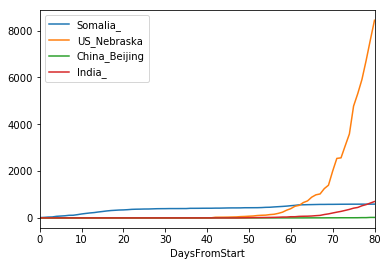

In [7]:
import matplotlib.pyplot as plt
import random
numReg = 5

selReg = random.choices(RegUniq, k=numReg)
dfTmp = dfTr[dfTr.Region.isin(selReg)]
selReg
fig = plt.figure()
ax = fig.add_subplot(111)

lines = dfTmp.groupby('Region').plot(x='DaysFromStart', y='ConfirmedCases', ax=ax)
ax.legend(selReg, loc='best')
plt.show()

#### First model: simple regression (polynomial model)

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

polyCC = PolynomialFeatures(degree = 4)
polyFAT = PolynomialFeatures(degree = 4)

regCC = LinearRegression()
regFAT = LinearRegression()

dfTeWithPred = dfTe.copy()

for i, tmpReg in enumerate(RegUniq):
    #print('Region: ' + str(i))
    dfSelTr = dfTr[dfTr.Region == tmpReg]
    dfSelTe = dfTe[dfTe.Region == tmpReg]
    
    XTr = np.array(dfSelTr.DaysFromStart).reshape([dfSelTr.shape[0],1])
    XTe = np.array(dfSelTe.DaysFromStart).reshape([dfSelTe.shape[0],1])

    yccTr = np.array(dfSelTr.ConfirmedCases)
    yfatTr = np.array(dfSelTr.Fatalities)
    
    X_poly = polyCC.fit_transform(XTr)
    regCC.fit(X_poly, yccTr)
    predCC = regCC.predict(polyCC.fit_transform(XTe))

    X_poly = polyFAT.fit_transform(XTr)
    regFAT.fit(X_poly, yfatTr)
    predFAT = regFAT.predict(polyFAT.fit_transform(XTe))
    
    ## Add predictions to test df
    dfTeWithPred.loc[dfSelTe.index,'ConfirmedCases'] = predCC
    dfTeWithPred.loc[dfSelTe.index,'Fatalities'] = predFAT
    
    

In [9]:
## Show predictions
dfTeWithPred.head()

,ForecastId,Province_State,Country_Region,Date,Region,DaysFromStart,ConfirmedCases,Fatalities
0,1,,Afghanistan,2020-04-02,Afghanistan_,71,240.952067,6.481849
1,2,,Afghanistan,2020-04-03,Afghanistan_,72,268.663150,7.357329
2,3,,Afghanistan,2020-04-04,Afghanistan_,73,298.530442,8.308596
3,4,,Afghanistan,2020-04-05,Afghanistan_,74,330.656072,9.339517
4,5,,Afghanistan,2020-04-06,Afghanistan_,75,365.144409,10.454048


In [10]:
## Prepare submission file
dfOut = dfTeWithPred[['ForecastId', 'ConfirmedCases', 'Fatalities']].round().astype(int)
dfOut.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,241,6
1,2,269,7
2,3,299,8
3,4,331,9
4,5,365,10


### Show predictions

Zimbabwe_


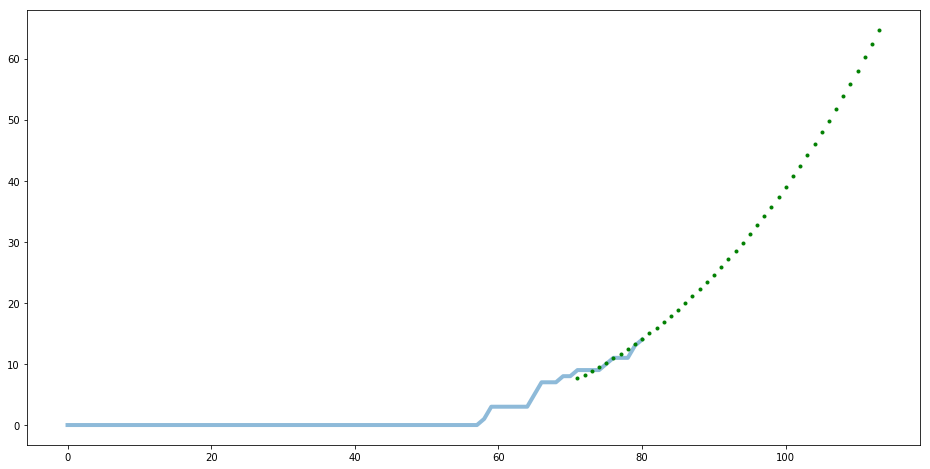

In [11]:
## Show predictions

print(tmpReg)

fig, ax = plt.subplots(figsize = [16, 8])

plt.plot(XTr, yccTr, linewidth = 4, alpha=0.5)
plt.plot(XTe, predCC, 'g.')
plt.show()


### Show predictions

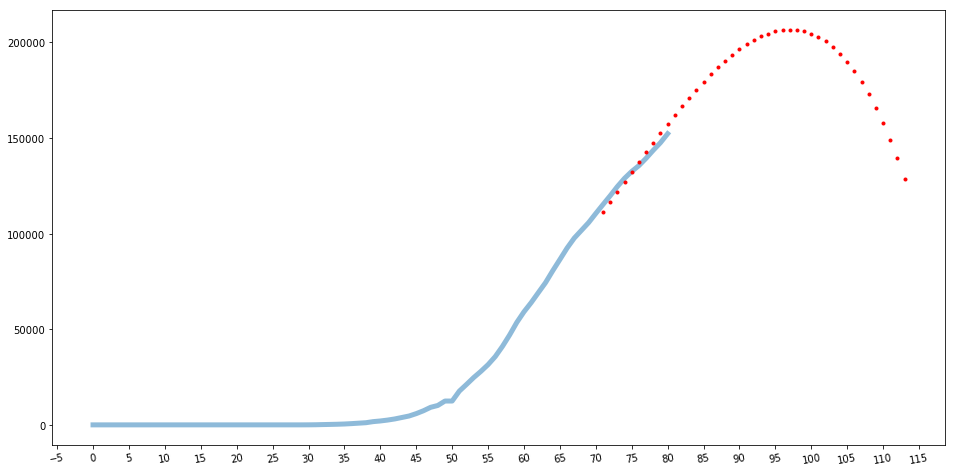

In [12]:
## Show predictions

SelReg = 'Sweden_'
SelReg = 'Italy_'
#SelReg = 'US_Pennsylvania'
SelVar = 'ConfirmedCases'
#SelVar = 'Fatalities'

dfSel = dfTr[dfTr.Region == SelReg]

xTr = dfSel.DaysFromStart
yTr = dfSel[SelVar]
dfSel = dfTeWithPred[dfTeWithPred.Region == SelReg]
xTe = dfSel.DaysFromStart
yTe = dfSel[SelVar]

fig, ax = plt.subplots(figsize = [16, 8])
fig.canvas.draw()

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.plot(xTr, yTr, linewidth=5, alpha=0.5)
ax.plot(xTe, yTe, 'r.')

plt.xticks(rotation=10)
plt.show()


### Show US predictions

In [13]:
dfTr[dfTr.Region.str.contains('US_')].Region.unique()

array(['US_Alabama', 'US_Alaska', 'US_Arizona', 'US_Arkansas',
       'US_California', 'US_Colorado', 'US_Connecticut', 'US_Delaware',
       'US_District of Columbia', 'US_Florida', 'US_Georgia', 'US_Guam',
       'US_Hawaii', 'US_Idaho', 'US_Illinois', 'US_Indiana', 'US_Iowa',
       'US_Kansas', 'US_Kentucky', 'US_Louisiana', 'US_Maine',
       'US_Maryland', 'US_Massachusetts', 'US_Michigan', 'US_Minnesota',
       'US_Mississippi', 'US_Missouri', 'US_Montana', 'US_Nebraska',
       'US_Nevada', 'US_New Hampshire', 'US_New Jersey', 'US_New Mexico',
       'US_New York', 'US_North Carolina', 'US_North Dakota', 'US_Ohio',
       'US_Oklahoma', 'US_Oregon', 'US_Pennsylvania', 'US_Puerto Rico',
       'US_Rhode Island', 'US_South Carolina', 'US_South Dakota',
       'US_Tennessee', 'US_Texas', 'US_Utah', 'US_Vermont',
       'US_Virgin Islands', 'US_Virginia', 'US_Washington',
       'US_West Virginia', 'US_Wisconsin', 'US_Wyoming'], dtype=object)

In [14]:
## Get all US data
dfTrUS = dfTr[dfTr.Country_Region=='US']
dfTrUS = dfTrUS.groupby(['Date','DaysFromStart'])[['ConfirmedCases','Fatalities']].sum().reset_index()
dfTrUS.head()

dfTeUS = dfTeWithPred[dfTeWithPred.Country_Region=='US']
dfTeUS = dfTeUS.groupby(['Date','DaysFromStart'])[['ConfirmedCases','Fatalities']].sum().reset_index()
dfTeUS.head()

,Date,DaysFromStart,ConfirmedCases,Fatalities
0,2020-04-02,71,231136.908537,6463.433216
1,2020-04-03,72,257973.686943,7496.010214
2,2020-04-04,73,286871.136896,8627.030271
3,2020-04-05,74,317924.959148,9861.829688
4,2020-04-06,75,351232.910306,11205.873458


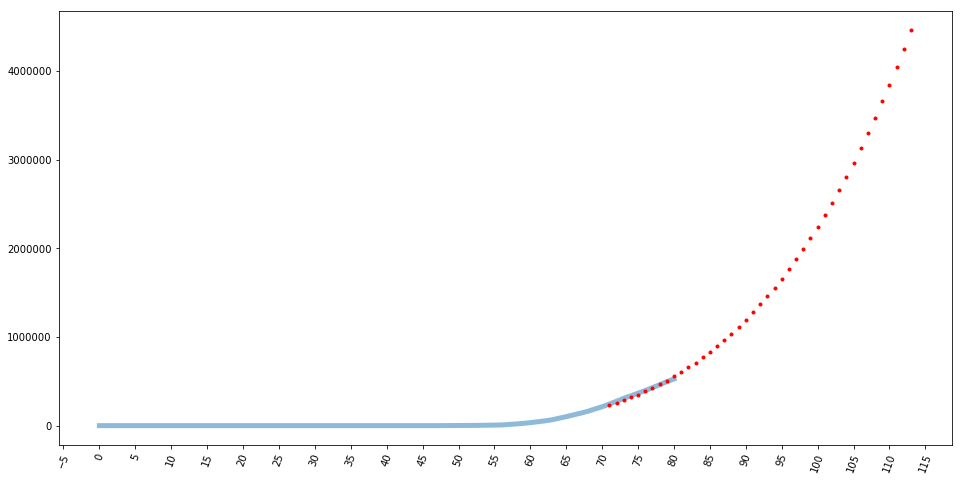

In [15]:
SelVar = 'ConfirmedCases'
#SelVar = 'Fatalities'

dfSelTr = dfTrUS
xTr = dfSelTr.DaysFromStart
yTr = dfSelTr[SelVar]

dfSelTe = dfTeUS
xTe = dfSelTe.DaysFromStart
yTe = dfSelTe[SelVar]

fig, ax = plt.subplots(figsize = [16, 8])
fig.canvas.draw()

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.plot(xTr, yTr, linewidth=5, alpha=0.5)
ax.plot(xTe, yTe, 'r.')
#plt.xticks(dfSel.Date.tolist())

plt.xticks(rotation=70)
plt.show()

#dfSelTr.Date.tolist()

#a,b = plt.xticks()
